# EDGE CLASSIFICATION

/DATA/sujit_2021cs35/anaconda3/envs/nlp/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Mapping labels: 100%|██████████| 3756/3756 [00:00<00:00, 319135.52it/s]
2025-03-09 01:22:05.028299: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-09 01:22:05.188277: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.

Number of clauses: 8
Number of annotations: 8
Node 0 attributes: {'text': ' ', 'type': [1, 0, 0]}
Node 1 attributes: {'text': 'you wanna see', 'type': [0, 1, 0]}
Node 2 attributes: {'text': 'a movie tomorrow ?', 'type': [1, 0, 0]}
Node 3 attributes: {'text': 'Sounds', 'type': [0, 0, 1]}
Node 4 attributes: {'text': 'like a good plan', 'type': [1, 0, 0]}
Node 5 attributes: {'text': 'What do you want', 'type': [1, 0, 0]}
Node 6 attributes: {'text': 'to see ?', 'type': [1, 0, 0]}
Node 7 attributes: {'text': 'How about Legally Blonde', 'type': [0, 0, 1]}


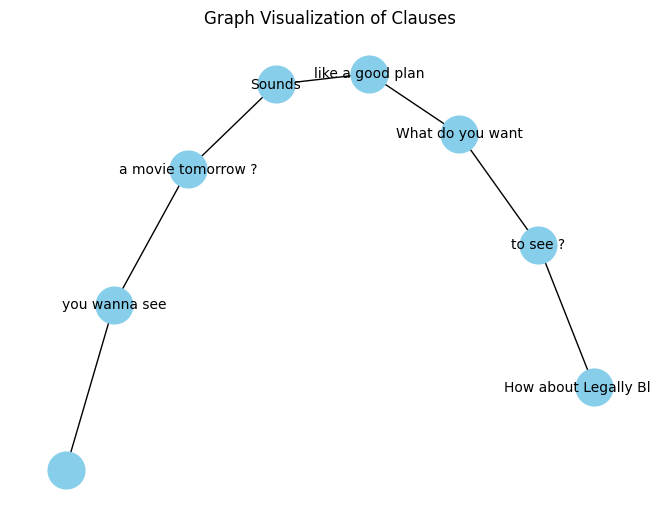

Epoch 20, Loss: 0.0976
Epoch 40, Loss: 0.0011
Epoch 60, Loss: 0.0002
Epoch 80, Loss: 0.0001
Epoch 100, Loss: 0.0001
Predicted emotion-cause pairs: [(0, 1), (2, 1)]


In [1]:
import json
import os
from tqdm import tqdm
import torch
import spacy
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from transformers import AutoTokenizer, AutoModel, AutoConfig
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data, Batch

# -------------------------
# 1. Load Data and Extract Clauses & Labels
# -------------------------

with open("/DATA/sujit_2021cs35/nlp_project/code/task 2/results_qwen_9pm.json", "r") as f:
    data = json.load(f)

all_clauses = []  # Each element will be a list of clause strings for one conversation.
all_label = []    # Each element will be a list of corresponding labels.

for conversation in tqdm(data.values(), desc="Processing conversations"):
    for dialogue in conversation:
        if "clauses" in dialogue and len(dialogue["clauses"]) != 0:
            temp_clauses = []
            temp_labels = []
            for clause in dialogue["clauses"]:
                temp_clauses.append(clause["clause"])
                temp_labels.append(clause["label"])
            all_clauses.append(temp_clauses)
            all_label.append(temp_labels)

# -------------------------
# 2. Create One-Hot Annotations for Each Clause
# -------------------------

label_map = {
    "emotion_clause": [1, 0, 0],
    "cause_clause":   [0, 1, 0],
    "neutral":        [0, 0, 1]
}

# For each conversation, convert labels to one-hot vectors.
annotations = []
for ann in tqdm(all_label, desc="Mapping labels"):
    anns = []
    for label in ann:
        anns.append(label_map.get(label, [0, 0, 1]))  # default to "neutral" if not found
    annotations.append(anns)

# -------------------------
# 3. Setup for Embeddings using BERT on CUDA
# -------------------------

device = 'cuda:0'
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-cased")
config = AutoConfig.from_pretrained("google-bert/bert-base-cased")
# Using from_pretrained to load weights; alternatively you can use from_config if needed.
bert_model = AutoModel.from_pretrained("google-bert/bert-base-cased", config=config)
bert_model.to(device)

def get_embeddings(clauses):
    """
    Given a list of clause strings, returns their BERT [CLS] token embeddings.
    """
    # Ensure we have a list even if a single string is passed.
    if isinstance(clauses, str):
        clauses = [clauses]
    inputs = tokenizer(clauses, return_tensors="pt", padding=True, truncation=True)
    # Move each tensor in the dict to the GPU.
    inputs = {k: v.to(device) for k, v in inputs.items()}
    outputs = bert_model(**inputs)
    # Return the [CLS] token embeddings and move them to CPU.
    return outputs.last_hidden_state[:, 0, :].detach().cpu()

# -------------------------
# 4. Define Graph Creation and Preparation Functions
# -------------------------

def create_graph(clauses, annotations):
    """
    Create a simple graph where each node is a clause and edges connect consecutive clauses.
    """
    G = nx.Graph()
    print(f"Number of clauses: {len(clauses)}")
    print(f"Number of annotations: {len(annotations)}")
    
    # Add nodes with attributes.
    for i, clause in enumerate(clauses):
        # Use provided annotation if available; otherwise default to [0, 0, 1].
        annotation = annotations[i] if i < len(annotations) else [0, 0, 1]
        G.add_node(i, text=clause, type=annotation)
    
    # Add consecutive edges.
    for i in range(len(clauses) - 1):
        G.add_edge(i, i + 1)
    
    # Optionally print node attributes.
    for node in G.nodes():
        print(f"Node {node} attributes: {G.nodes[node]}")
    
    return G

def prepare_data(G, embeddings):
    """
    Prepare PyTorch Geometric data from a NetworkX graph and node embeddings.
    """
    # embeddings is expected to be a tensor of shape (num_nodes, embedding_dim)
    x = embeddings  
    nodes = list(G.nodes())
    
    # Create edge_index from graph edges.
    edges = list(G.edges)
    if len(edges) > 0:
        edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    else:
        edge_index = torch.empty((2, 0), dtype=torch.long)
    
    # Extract node labels from graph attributes.
    labels = []
    for node in nodes:
        ann = G.nodes[node].get('type', [0, 0, 1])
        # Convert one-hot list to a class index.
        if isinstance(ann, list):
            label = ann.index(max(ann))
        else:
            label = ann
        labels.append(label)
    labels = torch.tensor(labels, dtype=torch.long)
    
    data = Data(x=x, edge_index=edge_index, y=labels)
    return [data]

# -------------------------
# 5. Define the GNN Model and Training Functions
# -------------------------

class GraphTransformer(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GraphTransformer, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index).relu()
        return self.fc(x)

def train_model(model, data_list, optimizer, criterion):
    model.train()
    optimizer.zero_grad()
    batch = Batch.from_data_list(data_list)
    out = model(batch.x, batch.edge_index)
    loss = criterion(out, batch.y)
    loss.backward()
    optimizer.step()
    return loss.item()

def predict_emotion_cause_pair(model, data):
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        pred = out.argmax(dim=1)
    
    # Define: label 0 -> emotion, label 1 -> cause.
    emotion_nodes = (pred == 0).nonzero(as_tuple=True)[0]
    cause_nodes = (pred == 1).nonzero(as_tuple=True)[0]
    
    pairs = []
    for emotion in emotion_nodes:
        for cause in cause_nodes:
            # Check if nodes are directly connected.
            if any((emotion.item() in edge and cause.item() in edge) for edge in data.edge_index.t().tolist()):
                pairs.append((emotion.item(), cause.item()))
    
    return pairs

# -------------------------
# 6. Visualize a Small Portion of the Graph
# -------------------------

# For visualization, we use the first conversation only.
if all_clauses:
    first_clauses = all_clauses[0]       # list of clause strings from the first conversation
    first_annotations = annotations[0]   # corresponding one-hot annotations
    # Compute embeddings for the first conversation.
    first_embeddings = get_embeddings(first_clauses)  # shape: (num_clauses, 768)
    
    # Create the graph from the first conversation.
    G = create_graph(first_clauses, first_annotations)
    data_list = prepare_data(G, first_embeddings)
    data = data_list[0]
    
    def visualize_graph(G):
        """
        Visualizes the graph with node texts (shortened if needed).
        """
        pos = nx.spring_layout(G)
        # Prepare node labels (shorten text if too long)
        node_labels = {}
        for node in G.nodes():
            text = G.nodes[node]['text']
            short_text = text if len(text) <= 30 else text[:30] + "..."
            node_labels[node] = short_text
        nx.draw(G, pos, with_labels=True, labels=node_labels,
                node_color='skyblue', edge_color='black', font_size=10, node_size=700)
        plt.title("Graph Visualization of Clauses")
        plt.show()
    
    visualize_graph(G)
    
    # -------------------------
    # 7. (Optional) Train the GNN Model on This Graph
    # -------------------------
    
    model = GraphTransformer(input_dim=768, hidden_dim=64, output_dim=3)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    criterion = torch.nn.CrossEntropyLoss()
    
    for epoch in range(100):
        loss = train_model(model, data_list, optimizer, criterion)
        if (epoch + 1) % 20 == 0:
            print(f"Epoch {epoch + 1}, Loss: {loss:.4f}")
    
    # Predict emotion-cause pairs.
    pairs = predict_emotion_cause_pair(model, data)
    print("Predicted emotion-cause pairs:", pairs)
else:
    print("No clauses available for visualization.")


# NODE CLASSIFICATION

Mapping labels: 100%|██████████| 3756/3756 [00:00<00:00, 225453.74it/s]


Number of clauses: 8
Number of annotations: 8
Node 0 attributes: {'text': ' ', 'type': [1, 0, 0]}
Node 1 attributes: {'text': 'you wanna see', 'type': [0, 1, 0]}
Node 2 attributes: {'text': 'a movie tomorrow ?', 'type': [1, 0, 0]}
Node 3 attributes: {'text': 'Sounds', 'type': [0, 0, 1]}
Node 4 attributes: {'text': 'like a good plan', 'type': [1, 0, 0]}
Node 5 attributes: {'text': 'What do you want', 'type': [1, 0, 0]}
Node 6 attributes: {'text': 'to see ?', 'type': [1, 0, 0]}
Node 7 attributes: {'text': 'How about Legally Blonde', 'type': [0, 0, 1]}


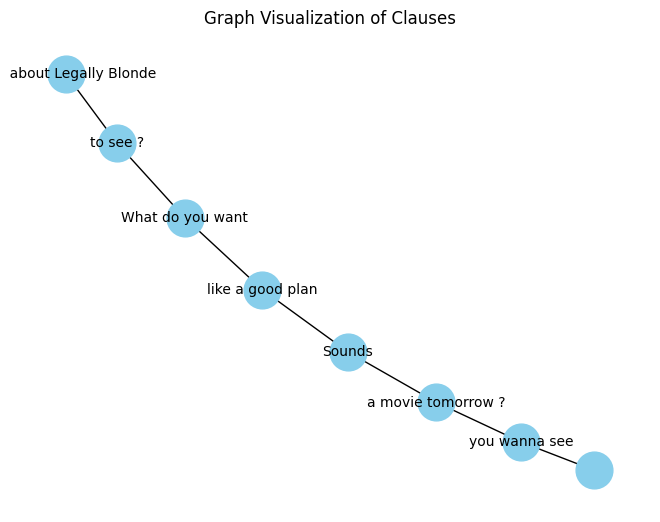

Epoch 20, Loss: 0.1724, Accuracy: 100.00%
Epoch 40, Loss: 0.0016, Accuracy: 100.00%
Epoch 60, Loss: 0.0002, Accuracy: 100.00%
Epoch 80, Loss: 0.0001, Accuracy: 100.00%
Epoch 100, Loss: 0.0001, Accuracy: 100.00%
Final node classification accuracy: 100.00%
Predicted emotion-cause pairs: [(0, 1), (2, 1)]


In [3]:
import json
import os
from tqdm import tqdm
import torch
import spacy
import networkx as nx
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModel, AutoConfig
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data, Batch

# -------------------------
# 1. Load Data and Extract Clauses & Labels
# -------------------------

with open("/DATA/sujit_2021cs35/nlp_project/code/task 2/results_qwen_9pm.json", "r") as f:
    data = json.load(f)
    
all_clauses = []  # List of lists. Each inner list is a conversation's clause strings.
all_label = []    # List of lists. Each inner list contains the corresponding labels.

for conversation in tqdm(data.values(), desc="Processing conversations"):
    for dialogue in conversation:
        if "clauses" in dialogue and len(dialogue["clauses"]) != 0:
            temp_clauses = []
            temp_labels = []
            for clause in dialogue["clauses"]:
                temp_clauses.append(clause["clause"])
                temp_labels.append(clause["label"])
            all_clauses.append(temp_clauses)
            all_label.append(temp_labels)

# -------------------------
# 2. Create One-Hot Annotations for Each Clause
# -------------------------

label_map = {
    "emotion_clause": [1, 0, 0],
    "cause_clause":   [0, 1, 0],
    "neutral":        [0, 0, 1]
}

annotations = []
for ann in tqdm(all_label, desc="Mapping labels"):
    anns = []
    for label in ann:
        anns.append(label_map.get(label, [0, 0, 1]))  # default to "neutral" if not found
    annotations.append(anns)

# -------------------------
# 3. Setup for BERT Embeddings (using CUDA)
# -------------------------

device = 'cuda:0'
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-cased")
config = AutoConfig.from_pretrained("google-bert/bert-base-cased")
bert_model = AutoModel.from_pretrained("google-bert/bert-base-cased", config=config)
bert_model.to(device)

def get_embeddings(clauses):
    """
    Given a list of clause strings, returns their BERT [CLS] token embeddings.
    """
    if isinstance(clauses, str):
        clauses = [clauses]
    inputs = tokenizer(clauses, return_tensors="pt", padding=True, truncation=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    outputs = bert_model(**inputs)
    return outputs.last_hidden_state[:, 0, :].detach().cpu()

# -------------------------
# 4. Graph Creation and Data Preparation
# -------------------------

def create_graph(clauses, annotations):
    """
    Create a simple graph where each node is a clause and consecutive nodes are connected.
    """
    G = nx.Graph()
    print(f"Number of clauses: {len(clauses)}")
    print(f"Number of annotations: {len(annotations)}")
    
    # Add nodes with text and one-hot type as attributes.
    for i, clause in enumerate(clauses):
        annotation = annotations[i] if i < len(annotations) else [0, 0, 1]
        G.add_node(i, text=clause, type=annotation)
    
    # Add consecutive edges.
    for i in range(len(clauses) - 1):
        G.add_edge(i, i + 1)
    
    for node in G.nodes():
        print(f"Node {node} attributes: {G.nodes[node]}")
    
    return G

def prepare_data(G, embeddings):
    """
    Prepares a PyTorch Geometric Data object using node embeddings and graph structure.
    """
    x = embeddings  # Expecting a tensor of shape (num_nodes, embedding_dim)
    nodes = list(G.nodes())
    
    # Create edge_index tensor from graph edges.
    edges = list(G.edges)
    if len(edges) > 0:
        edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    else:
        edge_index = torch.empty((2, 0), dtype=torch.long)
    
    # Extract node labels from graph attributes.
    labels = []
    for node in nodes:
        ann = G.nodes[node].get('type', [0, 0, 1])
        # Convert one-hot list to class index.
        label = ann.index(max(ann)) if isinstance(ann, list) else ann
        labels.append(label)
    labels = torch.tensor(labels, dtype=torch.long)
    
    data = Data(x=x, edge_index=edge_index, y=labels)
    return [data]

# -------------------------
# 5. Define the GNN Model and Training Functions
# -------------------------

class GraphTransformer(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GraphTransformer, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index).relu()
        return self.fc(x)

def train_model(model, data_list, optimizer, criterion):
    model.train()
    optimizer.zero_grad()
    batch = Batch.from_data_list(data_list)
    out = model(batch.x, batch.edge_index)
    loss = criterion(out, batch.y)
    loss.backward()
    optimizer.step()
    return loss.item()

def evaluate_model(model, data):
    """
    Evaluates the model's node classification accuracy on the provided data.
    """
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        pred = out.argmax(dim=1)
    correct = (pred == data.y).sum().item()
    total = data.y.size(0)
    accuracy = correct / total if total > 0 else 0
    return accuracy

def predict_emotion_cause_pair(model, data):
    """
    Predicts emotion-cause pairs based on node classifications.
    (Assuming label 0 corresponds to 'emotion' and label 1 corresponds to 'cause')
    """
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        pred = out.argmax(dim=1)
    
    # Identify nodes classified as 'emotion' and 'cause'
    emotion_nodes = (pred == 0).nonzero(as_tuple=True)[0]
    cause_nodes = (pred == 1).nonzero(as_tuple=True)[0]
    
    pairs = []
    # Form pairs if the nodes are directly connected.
    for emotion in emotion_nodes:
        for cause in cause_nodes:
            if any((emotion.item() in edge and cause.item() in edge) for edge in data.edge_index.t().tolist()):
                pairs.append((emotion.item(), cause.item()))
    
    return pairs

# -------------------------
# 6. Visualize a Small Portion of the Graph
# -------------------------

# For visualization and demonstration, we use the first conversation.
if all_clauses:
    first_clauses = all_clauses[0]       # list of clause strings from the first conversation
    first_annotations = annotations[0]   # corresponding one-hot annotations
    first_embeddings = get_embeddings(first_clauses)  # BERT embeddings for these clauses
    
    G = create_graph(first_clauses, first_annotations)
    data_list = prepare_data(G, first_embeddings)
    data = data_list[0]
    
    def visualize_graph(G):
        pos = nx.spring_layout(G)
        # Shorten node labels if necessary.
        node_labels = {}
        for node in G.nodes():
            text = G.nodes[node]['text']
            short_text = text if len(text) <= 30 else text[:30] + "..."
            node_labels[node] = short_text
        nx.draw(G, pos, with_labels=True, labels=node_labels,
                node_color='skyblue', edge_color='black', font_size=10, node_size=700)
        plt.title("Graph Visualization of Clauses")
        plt.show()
    
    visualize_graph(G)
    
    # -------------------------
    # 7. Train the GNN Model and Evaluate Node Classification Accuracy
    # -------------------------
    
    model = GraphTransformer(input_dim=768, hidden_dim=64, output_dim=3)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    criterion = torch.nn.CrossEntropyLoss()
    
    # Training loop with periodic accuracy evaluation.
    for epoch in range(100):
        loss = train_model(model, data_list, optimizer, criterion)
        if (epoch + 1) % 20 == 0:
            acc = evaluate_model(model, data)
            print(f"Epoch {epoch + 1}, Loss: {loss:.4f}, Accuracy: {acc*100:.2f}%")
    
    # Final evaluation
    acc_final = evaluate_model(model, data)
    print("Final node classification accuracy: {:.2f}%".format(acc_final * 100))
    
    # Predict emotion-cause pairs.
    pairs = predict_emotion_cause_pair(model, data)
    print("Predicted emotion-cause pairs:", pairs)
else:
    print("No clauses available for visualization.")


# whole data usage

In [4]:
# -------------------------
# 1. Load Data and Extract Clauses & Labels
# (Code remains unchanged)
# -------------------------

with open("/DATA/sujit_2021cs35/nlp_project/code/task 2/results_qwen_9pm.json", "r") as f:
    data = json.load(f)
    
all_clauses = []
all_label = []

for conversation in tqdm(data.values(), desc="Processing conversations"):
    for dialogue in conversation:
        if "clauses" in dialogue and len(dialogue["clauses"]) != 0:
            temp_clauses = []
            temp_labels = []
            for clause in dialogue["clauses"]:
                temp_clauses.append(clause["clause"])
                temp_labels.append(clause["label"])
            all_clauses.append(temp_clauses)
            all_label.append(temp_labels)

# -------------------------
# 2. Create One-Hot Annotations for Each Clause
# (Code remains unchanged)
# -------------------------

label_map = {
    "emotion_clause": [1, 0, 0],
    "cause_clause":   [0, 1, 0],
    "neutral":        [0, 0, 1]
}

annotations = []
for ann in tqdm(all_label, desc="Mapping labels"):
    anns = []
    for label in ann:
        anns.append(label_map.get(label, [0, 0, 1]))  # default to "neutral" if not found
    annotations.append(anns)

# -------------------------
# 3. Setup for BERT Embeddings (using CUDA)
# (Code remains unchanged)
# -------------------------

device = 'cuda:0'
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-cased")
config = AutoConfig.from_pretrained("google-bert/bert-base-cased")
bert_model = AutoModel.from_pretrained("google-bert/bert-base-cased", config=config)
bert_model.to(device)

# -------------------------
# 4. Graph Creation and Data Preparation Functions
# (Code remains unchanged)
# -------------------------

def create_graph(clauses, annotations):
    """
    Create a simple graph where each node is a clause and consecutive nodes are connected.
    """
    G = nx.Graph()
    for i, clause in enumerate(clauses):
        annotation = annotations[i] if i < len(annotations) else [0, 0, 1]
        G.add_node(i, text=clause, type=annotation)
    # Add consecutive edges.
    for i in range(len(clauses) - 1):
        G.add_edge(i, i + 1)
    return G

def prepare_data(G, embeddings):
    """
    Prepares a PyTorch Geometric Data object using node embeddings and graph structure.
    """
    x = embeddings  # Tensor of shape (num_nodes, embedding_dim)
    nodes = list(G.nodes())
    
    # Create edge_index tensor from graph edges.
    edges = list(G.edges)
    if len(edges) > 0:
        edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    else:
        edge_index = torch.empty((2, 0), dtype=torch.long)
    
    # Extract node labels from graph attributes.
    labels = []
    for node in nodes:
        ann = G.nodes[node].get('type', [0, 0, 1])
        # Convert one-hot list to class index.
        label = ann.index(max(ann)) if isinstance(ann, list) else ann
        labels.append(label)
    labels = torch.tensor(labels, dtype=torch.long)
    
    data = Data(x=x, edge_index=edge_index, y=labels)
    return data

# -------------------------
# 5. Define the GNN Model and Training Functions
# (Code remains unchanged)
# -------------------------

class GraphTransformer(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GraphTransformer, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index).relu()
        return self.fc(x)

def train_model(model, data_list, optimizer, criterion):
    model.train()
    optimizer.zero_grad()
    batch = Batch.from_data_list(data_list)
    out = model(batch.x, batch.edge_index)
    loss = criterion(out, batch.y)
    loss.backward()
    optimizer.step()
    return loss.item()

def evaluate_model(model, data_list):
    """
    Evaluates the model's node classification accuracy on the provided data.
    """
    model.eval()
    batch = Batch.from_data_list(data_list)
    with torch.no_grad():
        out = model(batch.x, batch.edge_index)
        pred = out.argmax(dim=1)
    correct = (pred == batch.y).sum().item()
    total = batch.y.size(0)
    accuracy = correct / total if total > 0 else 0
    return accuracy

# -------------------------
# 6. Train the Model on All Clauses and Annotations
# -------------------------

# Preparing data for all conversations.
data_list = []
for clauses, labels in tqdm(zip(all_clauses, annotations), total=len(all_clauses), desc="Preparing data"):
    embeddings = get_embeddings(clauses)
    G = create_graph(clauses, labels)
    data = prepare_data(G, embeddings)
    data_list.append(data)

# Define the model, optimizer, and loss criterion.
model = GraphTransformer(input_dim=768, hidden_dim=64, output_dim=3)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

# Training loop.
for epoch in range(100):
    loss = train_model(model, data_list, optimizer, criterion)
    if (epoch + 1) % 20 == 0:
        acc = evaluate_model(model, data_list)
        print(f"Epoch {epoch + 1}, Loss: {loss:.4f}, Accuracy: {acc*100:.2f}%")

# Final evaluation after training.
acc_final = evaluate_model(model, data_list)
print("Final node classification accuracy: {:.2f}%".format(acc_final * 100))


Preparing data: 100%|██████████| 3756/3756 [01:23<00:00, 45.04it/s]


Epoch 20, Loss: 0.9298, Accuracy: 52.38%
Epoch 40, Loss: 0.8914, Accuracy: 57.77%
Epoch 60, Loss: 0.8761, Accuracy: 59.23%
Epoch 80, Loss: 0.8747, Accuracy: 59.65%
Epoch 100, Loss: 0.8622, Accuracy: 60.00%
Final node classification accuracy: 60.00%


In [1]:
import json
import os

with open("/DATA/sujit_2021cs35/nlp_project/code/task 2/results_qwen_9pm.json", "r") as f:
    data = json.load(f)

In [2]:
from tqdm import tqdm

all_clauses = []
all_label = []

for conversation in tqdm(data.values()):
    for dialogue in conversation:

        if "clauses" in dialogue:
            if len(dialogue["clauses"]) != 0:
                
                temp_clauses = []
                temp_labels = []
                
                for clause in dialogue["clauses"]:
                    temp_clauses.append(clause["clause"])
                    temp_labels.append(clause["label"])
                    
                all_clauses.append(temp_clauses)
                all_label.append(temp_labels)
                
                
                    # if "clause" in clause:
                    #     all_clauses.append(clause["clause"])
                # print(dialogue["clauses"])
    #     break
    # break
        # for turn in dialogue:
        #     if "clause" in turn:
        #         all_clauses.append(turn["clause"])

100%|██████████| 834/834 [00:00<00:00, 26274.06it/s]


In [3]:
len(all_clauses)

3756

In [4]:
len(all_clauses[2])

8

In [5]:
all_label[0]

['emotion_clause',
 'cause_clause',
 'emotion_clause',
 'neutral',
 'emotion_clause',
 'emotion_clause',
 'emotion_clause',
 'neutral']

In [6]:

# Define a mapping from clause type to one-hot vector.
label_map = {
    "emotion_clause": [1, 0, 0],
    "cause_clause":   [0, 1, 0],
    "neutral": [0, 0, 1]
}

# Initialize an empty list to store annotations.
annotations = []

for ann in tqdm(all_label):
    # Initialize an empty list to store the one-hot vectors for each clause in the conversation.
    anns = []
    for label in ann:
        # Append the one-hot vector for the clause type.
        anns.append(label_map[label])
    # Append the list of one-hot vectors for the conversation.
    annotations.append(anns)


100%|██████████| 3756/3756 [00:00<00:00, 221818.98it/s]


In [ ]:
import torch
import spacy
import networkx as nx
from sklearn.preprocessing import OneHotEncoder
from transformers import AutoTokenizer, AutoModel, AutoConfig
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data, Batch

# Load Spacy for clause extraction
nlp = spacy.load("en_core_web_sm")
def extract_clauses(conversation):
    doc = nlp(conversation)
    return [sent.text for sent in doc.sents]

# Initialize tokenizer and model for embeddings
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-cased")
config = AutoConfig.from_pretrained("google-bert/bert-base-cased")
bert_model = AutoModel.from_config(config)
def get_embeddings(clauses):
    if isinstance(clauses, str):
        clauses = [clauses]
    inputs = tokenizer(clauses, return_tensors="pt", padding=True, truncation=True)
    outputs = bert_model(**inputs)
    return outputs.last_hidden_state[:, 0, :]

# OneHotEncoder setup for annotations (optional if you want to encode raw labels)
encoder = OneHotEncoder(sparse_output=False)

def create_graph(clauses, annotations):
    G = nx.Graph()
    print(f"Number of clauses: {len(clauses)}")
    print(f"Number of annotations: {len(annotations)}")
    
    # Add nodes with attributes.
    for i, clause in enumerate(clauses):
        # Use provided annotation if available; otherwise default to [0, 0, 1] (i.e., "other")
        annotation = annotations[i] if i < len(annotations) else [0, 0, 1]
        G.add_node(i, text=clause, type=annotation)
    
    # Add simple consecutive edges.
    for i in range(len(clauses) - 1):
        G.add_edge(i, i + 1)
    
    for node in G.nodes():
        print(f"Node {node} attributes: {G.nodes[node]}")
    
    return G

def prepare_data(G, embeddings):
    x = embeddings  # Node features from BERT.
    nodes = list(G.nodes())
    
    # Create edge_index from graph edges.
    edge_index = torch.tensor(list(G.edges), dtype=torch.long).t().contiguous()
    
    # Extract node labels from graph attributes.
    labels = []
    for node in nodes:
        ann = G.nodes[node].get('type', [0, 0, 1])
        # Convert one-hot encoded list to class index.
        if isinstance(ann, list):
            label = ann.index(max(ann))
        else:
            label = ann
        labels.append(label)
    labels = torch.tensor(labels, dtype=torch.long)
    
    data = Data(x=x, edge_index=edge_index, y=labels)
    return [data]

# Corrected GNN model for node-level classification.
class GraphTransformer(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GraphTransformer, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        # print(x.shape)
        x = self.conv2(x, edge_index).relu()
        return self.fc(x)

def train_model(model, data_list, optimizer, criterion):
    model.train()
    optimizer.zero_grad()
    batch = Batch.from_data_list(data_list)
    out = model(batch.x, batch.edge_index)
    loss = criterion(out, batch.y)
    loss.backward(retain_graph=True)
    optimizer.step()
    return loss.item()

def predict_emotion_cause_pair(model, data):
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        pred = out.argmax(dim=1)
    
    # Define: label 0 -> emotion, label 1 -> cause.
    emotion_nodes = (pred == 0).nonzero(as_tuple=True)[0]
    cause_nodes = (pred == 1).nonzero(as_tuple=True)[0]
    
    pairs = []
    for emotion in emotion_nodes:
        for cause in cause_nodes:
            # Check if nodes are directly connected.
            if any((emotion.item() in edge and cause.item() in edge) for edge in data.edge_index.t().tolist()):
                pairs.append((emotion.item(), cause.item()))
    
    return pairs

# --- Main execution ---

conversation = "I feel sad because it's raining. But I'm excited about the weekend."
# clauses = extract_clauses(conversation)
# all_clauses
clauses = all_clauses
# embeddings = get_embeddings(all_clauses)
#! need to save this
embeddings = []
for clause in tqdm(all_clauses):
    embeddings.append(get_embeddings(clause))
# embeddings = [get_embeddings(clause) for clause in all_clauses]
# Provide annotations for each clause.
# For instance:
#   First clause: emotion -> one-hot vector [1, 0, 0] (label 0)
#   Second clause: cause   -> one-hot vector [0, 1, 0] (label 1)
# annotations = [
#     [1, 0, 0],  # Emotion
#     [0, 1, 0]   # Cause
# ]

G = create_graph(clauses, annotations)
data_list = prepare_data(G, embeddings)
data = data_list[0]

# Initialize and train the node-level model.
model = GraphTransformer(input_dim=768, hidden_dim=64, output_dim=3)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

for epoch in range(100):
    loss = train_model(model, data_list, optimizer, criterion)
    # Optional: print loss periodically.
    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch + 1}, Loss: {loss:.4f}")

# Predict emotion-cause pairs.
pairs = predict_emotion_cause_pair(model, data)
print("Predicted emotion-cause pairs:", pairs)


/DATA/sujit_2021cs35/anaconda3/envs/nlp/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-03-09 00:51:26.433286: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-09 00:51:26.568214: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-09 00:51:26.602580: E tensorflow/stream_executor/cuda/cuda_blas

## V2

In [2]:
import torch
import spacy
import networkx as nx
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from transformers import AutoTokenizer, AutoModel, AutoConfig
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data, Batch

# Initialize tokenizer and model for embeddings
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
config = AutoConfig.from_pretrained("bert-base-cased")
bert_model = AutoModel.from_config(config)

# Load Spacy for clause extraction
nlp = spacy.load("en_core_web_sm")

# LabelEncoder for encoding the clause types (e.g., "emotion", "neutral")
label_encoder = LabelEncoder()

# Sample data to mimic the provided structure
sample_data = {
    "tr_4466": [
        [
            {
                "turn": 1,
                "speaker": "A",
                "utterance": "Hey, you wanna see a movie tomorrow ?",
                "emotion": "happiness",
                "expanded emotion cause evidence": [1],
                "expanded emotion cause span": ["see a movie tomorrow ?"],
                "clauses": ["Hey", "you wanna see", "a movie tomorrow ?"],
                "types": ["neutral", "neutral", "emotion"]
            }
        ]
    ]
}

# Custom Dataset class
class EmotionCauseDataset(Dataset):
    def __init__(self, data):
        self.data = data
        self.conversations = list(data.values())  # Extract conversations

        # Flatten clauses and types for each turn in each conversation
        self.clauses = []
        self.types = []

        for conversation in self.conversations:
            for turns in conversation:
                # 'turns' is now a list of dictionaries, so iterate through it
                for turn in turns:
                    self.clauses.extend(turn['clauses'])  # Collect clauses
                    self.types.extend(turn['types'])      # Collect types

        # Encode clause types (e.g., "neutral", "emotion")
        self.labels = label_encoder.fit_transform(self.types)

    def __len__(self):
        return len(self.clauses)

    def __getitem__(self, idx):
        clause = self.clauses[idx]
        label = self.labels[idx]
        return clause, label

# Function to get BERT embeddings; returns empty tensor if no clauses are given.
def get_embeddings(clauses):
    if not clauses:  # If list is empty, return empty tensor with correct feature dim.
        return torch.empty(0, 768)
    inputs = tokenizer(clauses, return_tensors="pt", padding=True, truncation=True)
    outputs = bert_model(**inputs)
    return outputs.last_hidden_state[:, 0, :]  # Use the [CLS] token embedding

# Graph creation function
def create_graph(clauses, labels):
    G = nx.Graph()
    
    # Add nodes with attributes.
    for i, clause in enumerate(clauses):
        label = labels[i]
        G.add_node(i, text=clause, label=label)
    
    # Add consecutive edges.
    for i in range(len(clauses) - 1):
        G.add_edge(i, i + 1)
    
    return G

# Prepare data into PyG format
def prepare_data(G, embeddings):
    edge_index = torch.tensor(list(G.edges), dtype=torch.long).t().contiguous()
    node_labels = torch.tensor([G.nodes[node]['label'] for node in G.nodes()], dtype=torch.long)
    x = embeddings  # Use BERT embeddings as node features
    return Data(x=x, edge_index=edge_index, y=node_labels)

# Dataloader collate function
def collate_fn(batch):
    clauses, labels = zip(*batch)
    embeddings = get_embeddings(clauses)
    return clauses, embeddings, labels

# Custom GNN model for node-level classification
class GraphTransformer(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GraphTransformer, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index).relu()
        return self.fc(x)

# Create dataset and dataloader
dataset = EmotionCauseDataset(sample_data)
dataloader = DataLoader(dataset, batch_size=2, collate_fn=collate_fn)

# Initialize model, optimizer, and loss criterion
model = GraphTransformer(input_dim=768, hidden_dim=64, output_dim=len(label_encoder.classes_))
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

# Training loop
for epoch in range(100):
    for batch in dataloader:
        clauses, embeddings, labels = batch
        
        # Skip this batch if embeddings is empty.
        if embeddings.size(0) == 0:
            continue
        
        G = create_graph(clauses, labels)  # Create graph for the batch
        data = prepare_data(G, embeddings)  # Convert graph to PyG Data format
        
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)  # Forward pass
        loss = criterion(out, data.y)  # Compute loss
        loss.backward()
        optimizer.step()
    
    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch + 1}, Loss: {loss.item():.4f}")


IndexError: index 0 is out of bounds for dimension 0 with size 0

In [ ]:
# import torch
# import spacy
# import networkx as nx
# from torch.utils.data import Dataset, DataLoader
# from sklearn.preprocessing import LabelEncoder
# from transformers import AutoTokenizer, AutoModel, AutoConfig
# from torch_geometric.nn import GCNConv
# from torch_geometric.data import Data, Batch

# # Initialize tokenizer and model for embeddings
# tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
# config = AutoConfig.from_pretrained("bert-base-cased")
# bert_model = AutoModel.from_config(config)

# # Load Spacy for clause extraction
# nlp = spacy.load("en_core_web_sm")

# # LabelEncoder for encoding the clause types (e.g., "emotion", "neutral")
# label_encoder = LabelEncoder()

# # Sample data to mimic the provided structure
# sample_data = {
#   "tr_4466": [
#     [
#       {
#         "turn": 1,
#         "speaker": "A",
#         "utterance": "Hey, you wanna see a movie tomorrow ?",
#         "emotion": "happiness",
#         "expanded emotion cause evidence": [1],
#         "expanded emotion cause span": ["see a movie tomorrow ?"],
#         "clauses": ["Hey", "you wanna see", "a movie tomorrow ?"],
#         "types": ["neutral", "neutral", "emotion"]
#       }
#     ]
#   ]
# }

# # Custom Dataset class
# class EmotionCauseDataset(Dataset):
#     def __init__(self, data):
#         self.data = data
#         self.conversations = list(data.values())  # Extract conversations

#         # Flatten clauses and types for each turn in each conversation
#         self.clauses = []
#         self.types = []

#         for conversation in self.conversations:
#             for turns in conversation:
#                 # 'turns' is now a list of dictionaries, so iterate through it
#                 for turn in turns:
#                     self.clauses.extend(turn['clauses'])  # Collect clauses
#                     self.types.extend(turn['types'])      # Collect types

#         # Encode clause types (emotion, neutral, etc.)
#         self.labels = label_encoder.fit_transform(self.types)

#     def __len__(self):
#         return len(self.clauses)

#     def __getitem__(self, idx):
#         clause = self.clauses[idx]
#         label = self.labels[idx]
#         return clause, label


# # Function to get BERT embeddings
# def get_embeddings(clauses):
#     inputs = tokenizer(clauses, return_tensors="pt", padding=True, truncation=True)
#     outputs = bert_model(**inputs)
#     return outputs.last_hidden_state[:, 0, :]  # Use the [CLS] token embedding

# # Graph creation function
# def create_graph(clauses, labels):
#     G = nx.Graph()

#     # Add nodes with attributes
#     for i, clause in enumerate(clauses):
#         label = labels[i]
#         G.add_node(i, text=clause, label=label)
    
#     # Add consecutive edges
#     for i in range(len(clauses) - 1):
#         G.add_edge(i, i + 1)

#     return G

# # Prepare data into PyG format
# def prepare_data(G, embeddings):
#     edge_index = torch.tensor(list(G.edges), dtype=torch.long).t().contiguous()
#     labels = torch.tensor([G.nodes[node]['label'] for node in G.nodes()], dtype=torch.long)
#     x = embeddings  # Use BERT embeddings as node features

#     return Data(x=x, edge_index=edge_index, y=labels)

# # Dataloader function
# def collate_fn(batch):
#     clauses, labels = zip(*batch)
#     embeddings = get_embeddings(clauses)
#     return clauses, embeddings, labels

# # Custom GNN model
# class GraphTransformer(torch.nn.Module):
#     def __init__(self, input_dim, hidden_dim, output_dim):
#         super(GraphTransformer, self).__init__()
#         self.conv1 = GCNConv(input_dim, hidden_dim)
#         self.conv2 = GCNConv(hidden_dim, hidden_dim)
#         self.fc = torch.nn.Linear(hidden_dim, output_dim)

#     def forward(self, x, edge_index):
#         x = self.conv1(x, edge_index).relu()
#         x = self.conv2(x, edge_index).relu()
#         return self.fc(x)

# # Sample execution
# dataset = EmotionCauseDataset(sample_data)
# dataloader = DataLoader(dataset, batch_size=2, collate_fn=collate_fn)

# # Initialize model, optimizer, and loss
# model = GraphTransformer(input_dim=768, hidden_dim=64, output_dim=len(label_encoder.classes_))
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
# criterion = torch.nn.CrossEntropyLoss()

# # Training loop
# for epoch in range(100):
#     for batch in dataloader:
#         clauses, embeddings, labels = batch
#         G = create_graph(clauses, labels)  # Create graph for the batch
#         data = prepare_data(G, embeddings)  # Convert graph to PyG data format
        
#         optimizer.zero_grad()
#         out = model(data.x, data.edge_index)  # Forward pass
#         loss = criterion(out, data.y)  # Compute loss
#         loss.backward()
#         optimizer.step()

#     # Print loss every 20 epochs
#     if (epoch + 1) % 20 == 0:
#         print(f"Epoch {epoch + 1}, Loss: {loss.item():.4f}")



/DATA/sujit_2021cs35/anaconda3/envs/nlp/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-03-08 23:58:06.499871: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-08 23:58:06.634167: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-08 23:58:06.669020: E tensorflow/stream_executor/cuda/cuda_blas

IndexError: index 0 is out of bounds for dimension 0 with size 0